In [1]:
from sklearn import manifold
import matplotlib.pyplot as plt
import scipy, os
import tensorflow as tf
import pickle
from boundary_tree import *

from tensorflow_utils import *
from general import *
from data_ops import *
import logging_utils as logging

logger = logging.setup_logger(file='../logs/supbset.log')
cache_dir = '../cache'

    
class BasicNNet:
    def __init__(self, dim_data, dim_layers, dim_pred, dropout, params_init):
        self.dim_pred = dim_pred
        self.data = tf.placeholder("float", [None, dim_data])
        self.pred, self.weight_loss, self.params = BasicNNet.build_model(
            self.data, dim_layers, dim_pred, dropout, params_init)

    @staticmethod
    def build_model(data, dim_layers, dim_pred, keep_prob, params_init):
        params = []
        z = None
        weight_loss = tf.constant([0.])
        data_prev = data
        for dim_layer, index in zip(dim_layers + [dim_pred], range(len(dim_layers) + 1)):
            z, w, b = BasicNNet.build_layer(data_prev, dim_layer, None if params_init is None else params_init[index])
            params.append((w, b))
            weight_loss += tf.reduce_sum(tf.square(w))
            act = tf.nn.relu(z)
            if index>0 and keep_prob is not None:
                data_prev = tf.nn.dropout(act, keep_prob)
            else:
                data_prev = act

        return z, weight_loss, params

    @staticmethod
    def build_layer(data_prev, dim_layer, lay_init):
        if lay_init is None:
            dim_layer_prev = data_prev.get_shape().as_list()[1]
            std_dev = tf.sqrt(3./(dim_layer_prev + dim_layer))
            w_init = tf.truncated_normal([dim_layer_prev, dim_layer], stddev=std_dev)
            b_init = tf.zeros([dim_layer])  # random_normal
        else:
            w_init, b_init = lay_init

        w = tf.Variable(w_init)
        b = tf.Variable(b_init)
        z = tf.matmul(data_prev, w) + b
        return z, w, b

    
class BoundaryModel:
    def __init__(self, dim_data, dim_layers, dim_inter, dim_pred, sigma, dropout, params_init):
        self.debug = []
        self.dim_inter = dim_inter
        self.dim_pred = dim_pred
        self.__nnet = BasicNNet(dim_data, dim_layers, dim_inter, dropout, params_init)
        self.bnd_data = tf.placeholder("float", [None, dim_inter])
        self.bnd_target = tf.placeholder("float", [None, dim_pred])
        self.pred = self.calc_pred(self.inter, self.bnd_data, self.bnd_target, sigma)
        
    def calc_pred(self, data, bnd_data, bnd_target, sigma):
        # pairwise distance matrix
        q = tf.expand_dims(data, 1)
        m = tf.tile(q, [1, tf.shape(bnd_data)[0], 1]) - bnd_data
        s = tf.reduce_sum(tf.square(m), 2)
        dists2 = s
        dists = tf.sqrt(s)
        
        # gradient of py_func is none
        # https://stackoverflow.com/questions/41535347/how-gradient-passed-by-tf-py-func
        # d = tf.py_func(cdist, [data, bnd_data], tf.float32)

        # class probability matrix
        sm = tf.nn.softmax(-dists2/sigma)
        p = tf.matmul(sm, bnd_target)
        # self.debug.extend([data, bnd_data, bnd_target, dists, dists2, tf.nn.softmax(-dists), sm])
        # self.debug.extend([s, tf.reduce_prod(tf.sign(s), [0,1])])
        return p

    @property
    def data(self): return self.__nnet.data
    @property
    def inter(self): return self.__nnet.pred
    @property
    def weight_loss(self): return self.__nnet.weight_loss
    @property
    def params(self): return self.__nnet.params

    
class BasicTrainer(object):
    def __init__(self, model, regularizer, learning_rate, train_data, train_labels, batch_size,
                 test_data, test_labels, dump_freq, optimizer=None, decrease_learning_rate_at=[]):
        self.model = model
        self.debug = []
        self.target = tf.placeholder("float", [None, model.dim_pred])
        self.is_correct = tf.equal(tf.argmax(model.pred, 1), tf.argmax(self.target, 1))
        # self.debug.append(self.target)
        self.test_error = 100*(1 - tf.reduce_mean(tf.cast(self.is_correct, "float")))

        # calculate loss
        self.entropy_loss = self.calc_entropy_loss(model.pred, self.target)
        total_loss = self.entropy_loss + regularizer*self.model.weight_loss
        self.learning_rate_var = tf.Variable(learning_rate, trainable=False)
        self.learning_rate = learning_rate
        self.decrease_learning_rate_at = decrease_learning_rate_at
        self.optimizer = (optimizer if optimizer is not None else 
                          tf.train.AdamOptimizer)(learning_rate=self.learning_rate_var).minimize(total_loss)
        #vself.debug.append([self.entropy_loss, model.pred, tf.train.AdamOptimizer(learning_rate=learning_rate).compute_gradients(self.entropy_loss)])
        
        self.trainingPipe = DataSet(train_data, train_labels)
        self.train_data = train_data
        self.train_labels = train_labels
        self.batch_size = batch_size
        self.test_data = test_data
        self.test_labels = test_labels
        self.dump_freq = dump_freq

        self.history = []
        self.last_epoch = -1
        self.last_state = None
        
    def train(self, n_epochs, sess):
        logger.info("Starting training." if self.trainingPipe.epochs_completed<1
                    else "Continuing from epoch %d."%self.trainingPipe.epochs_completed)
        try:
            while self.trainingPipe.epochs_completed < n_epochs:
                m = self.model

                batch_data, batch_labels = self.trainingPipe.next_batch(self.batch_size)
                #self.test_data, self.test_labels = batch_data, batch_labels
                test_feed_dict = {m.data: self.test_data, self.target: convert_one_hot(self.test_labels, m.dim_pred)}
                train_feed_dict = {m.data: batch_data, self.target: convert_one_hot(batch_labels, m.dim_pred),
                                   self.learning_rate_var:self.learning_rate}
                self.setup_train_step(test_feed_dict, train_feed_dict, sess)
                _, entropy_loss = sess.run([self.optimizer, self.entropy_loss], train_feed_dict)

                if self.trainingPipe.epochs_completed > self.last_epoch:
                    self.last_epoch = self.trainingPipe.epochs_completed
                    is_correct, test_error = sess.run([self.is_correct, self.test_error], test_feed_dict)
                    #self.logger.debug(sess.run(self.debug, train_feed_dict))
                    logger.debug("Epoch: %d, Loss: %.3f, Pred error: %.3f" % (self.last_epoch, entropy_loss, test_error))
                    params = [sess.run(lay) for lay in m.params]
                    state_lite = {'entropy_loss': entropy_loss, 'test_error': test_error}
                    state_full = {'train_data': self.train_data, 'train_labels': self.train_labels,
                                  'test_data': self.test_data, 'test_labels': self.test_labels,
                                  'is_correct': is_correct, 'params': params}
                    state_full.update(state_lite)
                    self.setup_states(state_lite, state_full, sess)
                    self.history.append(state_lite)
                    self.last_state = state_full
                    if self.last_epoch % self.dump_freq == 0:
                        dump_pik('%s/temp_state_%d.pik' %(cache_dir, self.last_epoch), state_full)
                    if self.last_epoch in self.decrease_learning_rate_at:
                        logger.debug("Old learning_rate: %f"%self.learning_rate)
                        self.learning_rate /= 10.0
                        logger.debug("New learning_rate: %f"%self.learning_rate)
            logger.info("Finished training.")
        except KeyboardInterrupt:
            logger.info("Interrupt received.")
    
        return {'history': self.history, 'last_state': self.last_state}

        
class BasicNNetTrainer(BasicTrainer):
    def calc_entropy_loss(self, pred, target):
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=target))

    def setup_train_step(self, test_feed_dict, train_feed_dict, sess):
        pass

    def setup_states(self, state_lite, state_full, sess):
        train_trans = sess.run(self.model.pred, feed_dict={self.model.data: self.train_data})
        test_trans = sess.run(self.model.pred, feed_dict={self.model.data: self.test_data})
        state_full.update({'train_trans': train_trans, 'test_trans': test_trans})

    
class BoundaryTrainer(BasicTrainer):
    def __init__(self, model, regularizer, learning_rate, train_data, train_labels,
                 set_size, batch_size, test_data, test_labels, dump_freq, optimizer=None, decrease_learning_rate_at=[]):
        super(BoundaryTrainer, self).__init__(model, regularizer, learning_rate, train_data, train_labels,
                         batch_size, test_data, test_labels, dump_freq, optimizer, decrease_learning_rate_at)
        self.set_size = set_size
        self.temp_data = None
        self.debug.extend(model.debug)

    def calc_entropy_loss(self, pred, target):
        # https://stackoverflow.com/questions/33712178/tensorflow-nan-bug
        cor = tf.clip_by_value(pred,1e-8,1.0) # pred + 1e-8
        ttf = target * tf.log(cor)
        el = -tf.reduce_sum(ttf, [1])
        #eq = tf.equal(target, 1)
        #locs = tf.where(eq)
        #locs = tf.cast(locs, tf.int32)
        #ttf = tf.gather_nd(pred, locs)
        #el = -tf.log(ttf)
        return tf.reduce_mean(el)

    def setup_train_step(self, test_feed_dict, train_feed_dict, sess):
        set_data, set_labels = self.trainingPipe.next_batch(self.set_size)
        set_inter = sess.run(self.model.inter, feed_dict={self.model.data: set_data})
        b_set = build_boundary_set(set_inter, set_labels)
        feed_dict = {self.model.bnd_data: b_set.values, self.model.bnd_target:
                     convert_one_hot(b_set.labels, self.model.dim_pred)}
        test_feed_dict.update(feed_dict)
        train_feed_dict.update(feed_dict)
        self.temp_data = {'set_data': set_data, 'set_labels': set_labels,
                          'set_inter': set_inter, 'b_set': b_set}

    def setup_states(self, state_lite, state_full, sess):
        b_set = self.temp_data['b_set']
        logger.debug("Set size: %d" % b_set.size)
        train_trans = sess.run(self.model.inter, feed_dict={self.model.data: self.train_data})
        test_trans = sess.run(self.model.inter, feed_dict={self.model.data: self.test_data})
        state_lite.update({'b_set_size': b_set.size})
        state_full.update({'b_set_size': b_set.size, 'train_trans': train_trans, 'test_trans': test_trans})
        state_full.update(self.temp_data)
        self.temp_data = None
    

def get_hash_path(a):
    a.flags.writeable = False
    h = hash(a.tobytes())
    return cache_dir + '/' + str(h)


def load_cache(d):
    f = get_hash_path(d)
    return load_pik(f) if os.path.isfile(f) else None

    
def save_cache(d, c): dump_pik(get_hash_path(d), c)
def final_average(el): return np.mean(el[-int(len(el)*.2):])
    
def plot_TSNE__(data, labels, title):
    trans = load_cache(data)
    if trans is None:
        tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
        trans = tsne.fit_transform(data)
        save_cache(data, trans)

    plt.scatter(trans[:, 0], trans[:, 1], marker='*', s=5, edgecolor='none', c=labels)
    plt.ylabel(title)

    for i in range(max(labels)+1):
        indices = labels == i
        center = np.average(trans[indices], 0)
        plt.text(center[0], center[1], str(i), fontsize=20, weight="bold")

    plt.show()
    
    
def prod_perf_curves(history):
    ax1 = plt.subplot(311)
    el = fetch_field(history, 'entropy_loss')
    plt.plot(el)
    plt.ylabel('Entropy loss')
    plt.grid()
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax2 = plt.subplot(312)
    te = fetch_field(history, 'test_error')
    plt.plot(te)
    plt.ylabel('Test error')
    plt.grid()

    if is_field(history, 'b_set_size'):
        ax3 = plt.subplot(313, sharex=ax1)
        plt.plot(fetch_field(history, 'b_set_size'))
        plt.xlabel('Epoch')
        plt.ylabel('Boundary set size')
        plt.grid()
        plt.setp(ax2.get_xticklabels(), visible=False)
    else:
        plt.xlabel('Epoch')

    plt.show()
    logger.info("Entropy loss: %.2f, Test error: %.2f"%(final_average(el), final_average(te)))

    
def prod_tsne(state, subset):
    train_data = state['train_data']
    train_trans = state['train_trans']
    train_labels = state['train_labels']
    if subset>0:
        d, t, l = train_data[:subset], train_trans[:subset], train_labels[:subset]
    else:
        d, t, l = train_data, train_trans, train_labels
    plot_TSNE__(t, l, 'TSNE for transformed data')
    plot_TSNE__(d, l, 'TSNE for original data')
    

def save_result(sim_id, result):
    dump_pik('%s/%s_result.pik' %(cache_dir, sim_id), result)

    
def prod_report(report, subset):
    prod_perf_curves(report['history'])
    prod_tsne(report['last_state'], subset)


xy__ = lambda data: (data[:, 0], data[:, 1])

def prod_report_2d(report):
    prod_perf_curves(report['history'])
    state = report['last_state']
    b_set = state['b_set'] if 'b_set' in state else None
        
    plt.ylabel('Original data')
    plt.scatter(*xy__(state['train_data']), marker='.', s=5, c=state['train_labels'], edgecolor='none', label='Training data')
    plt.scatter(*xy__(state['test_data']), marker='o', s=25, c=state['test_labels'], edgecolor='none', label='Test data')
    if b_set:
        plt.scatter(*xy__(state['set_data']), marker='x', s=25, c=state['set_labels'], edgecolor='none', label='Set data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    plt.scatter(*xy__(state['train_trans']), marker='.', s=5, c=state['train_labels'], edgecolor='none', label='Training data')
    plt.scatter(*xy__(state['test_trans']), marker='o', s=25, c=state['test_labels'], edgecolor='none', label='Test data')
    if b_set:
        plt.ylabel('Transformed data with last boundary set')
        plt.scatter(*xy__(state['set_inter']), marker='x', s=25, c=state['set_labels'], edgecolor='none', label='Set training data')
        plt.scatter(*xy__(b_set.values), marker='s', s=40, facecolors='none', color='k', label='Set data')
    else:
        plt.ylabel('Transformed data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    plt.ylabel('Transformed test set in last state')
    plt.scatter(*xy__(state['test_trans']), marker='.', s=25, c=state['test_labels'], edgecolor='none', label='Test data')
    plt.scatter(*xy__(state['test_trans'][~state['is_correct']]), marker='o', s=40, facecolors='none', color='k', label='False positives')
    if b_set:
        plt.scatter(*xy__(b_set.values), marker='s', s=25, c=b_set.labels, edgecolor='none', label='Set data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()


def prod_trans_2d(report):
    prod_perf_curves(report['history'])
    state = report['last_state']
    trans = state['train_trans']
    labels = state['train_labels']
    
    plt.scatter(trans[:, 0], trans[:, 1], marker='*', s=5, edgecolor='none', c=labels)
    for i in range(max(labels)+1):
        indices = labels == i
        center = np.average(trans[indices], 0)
        plt.text(center[0], center[1], str(i), fontsize=20, weight="bold")

    plt.show()
        

def prod_report_easy(sim_id, func, trainer, n_epochs, subset=0):
    path = cache_dir + '/' + sim_id
    if os.path.isfile(path):
        logger.info("Loading cached training data [%s]"%path)
        result = load_pik(path)
    else:
        sess = setup_sess()
        result = trainer.train(n_epochs, sess=sess)
        dump_pik(path, result)
    
    if subset==0:
        func(result)
    else:
        func(result, subset)

# Half-moons on neural net with gradient descent optimizer

2017-11-05 13:26:21,145|root|INFO|Loading cached training data [../cache/hm_nn_gdo]


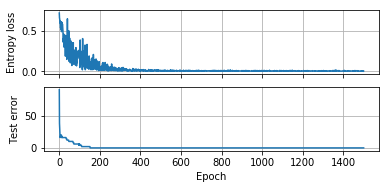

2017-11-05 13:26:21,477|root|INFO|Entropy loss: 0.00, Test error: 0.00


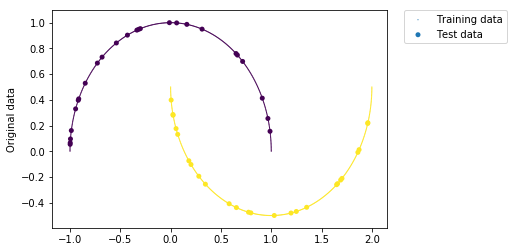

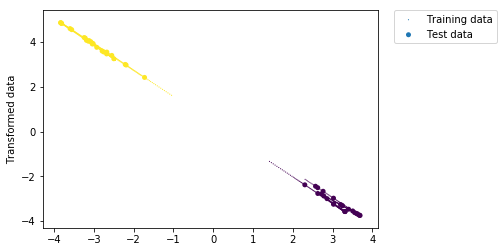

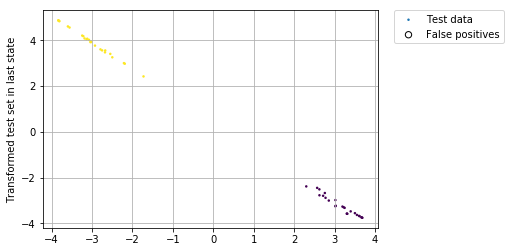

In [30]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BasicNNet(dim_data=2, dim_layers=[100, 100, 30], dim_pred=2, dropout=None, params_init=None)
trainer = BasicNNetTrainer(model=model, regularizer=.001, learning_rate=.001,
                           train_data=train_data, train_labels=train_labels, batch_size=10,
                           test_data=test_data, test_labels=test_labels, dump_freq=100,
                           optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('hm_nn_gdo', prod_report_2d, trainer, n_epochs=1500)

# Half-moons on neural net with gradient descent optimizer (with dropout)

2017-11-05 13:26:22,517|root|INFO|Loading cached training data [../cache/hm_nn_gdo_do]


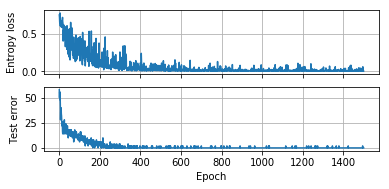

2017-11-05 13:26:22,864|root|INFO|Entropy loss: 0.01, Test error: 0.09


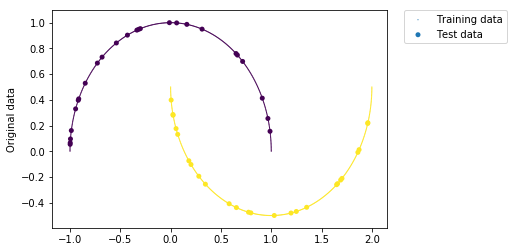

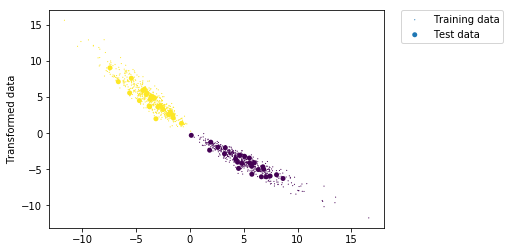

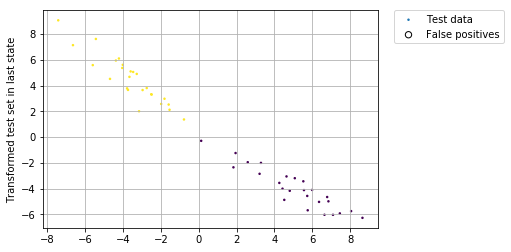

In [31]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BasicNNet(dim_data=2, dim_layers=[100, 100, 30], dim_pred=2, dropout=.5, params_init=None)
trainer = BasicNNetTrainer(model=model, regularizer=.001, learning_rate=.001,
                           train_data=train_data, train_labels=train_labels, batch_size=10,
                           test_data=test_data, test_labels=test_labels, dump_freq=100,
                           optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('hm_nn_gdo_do', prod_report_2d, trainer, n_epochs=1500)

# Half-moons on neural net with gradient descent optimizer (with dropout except 1st layer)

2017-11-05 13:26:24,018|root|INFO|Loading cached training data [../cache/hm_nn_gdo_do_1]


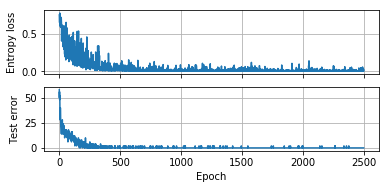

2017-11-05 13:26:24,325|root|INFO|Entropy loss: 0.01, Test error: 0.03


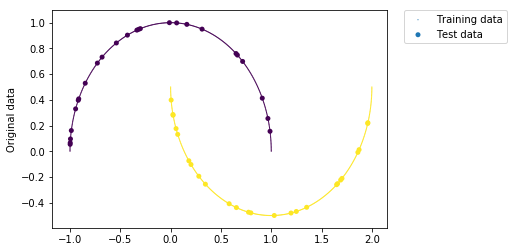

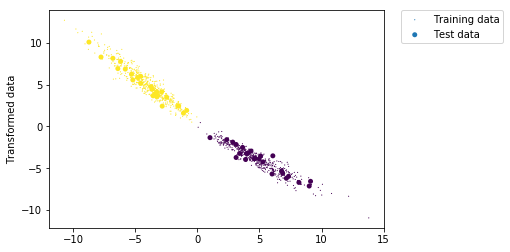

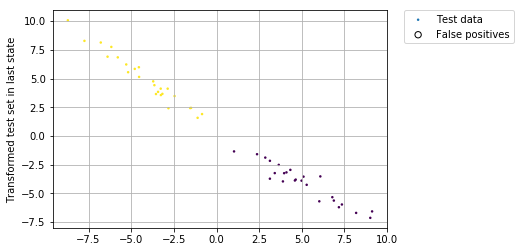

In [32]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BasicNNet(dim_data=2, dim_layers=[100, 100, 30], dim_pred=2, dropout=.5, params_init=None)
trainer = BasicNNetTrainer(model=model, regularizer=.001, learning_rate=.001,
                           train_data=train_data, train_labels=train_labels, batch_size=10,
                           test_data=test_data, test_labels=test_labels, dump_freq=100,
                           optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('hm_nn_gdo_do_1', prod_report_2d, trainer, n_epochs=2500)

# Half-moons on neural net with Adam optimizer

2017-11-05 13:26:25,453|root|INFO|Loading cached training data [../cache/hm_nn_ado]


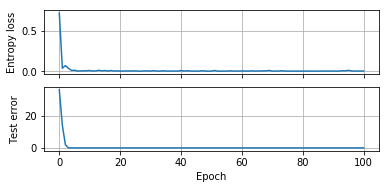

2017-11-05 13:26:25,787|root|INFO|Entropy loss: 0.00, Test error: 0.00


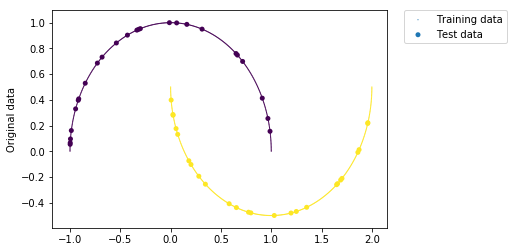

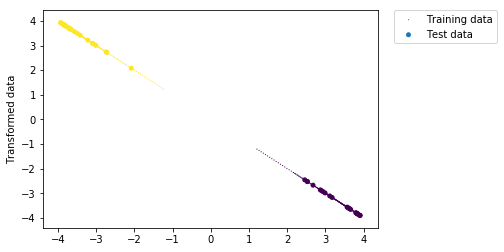

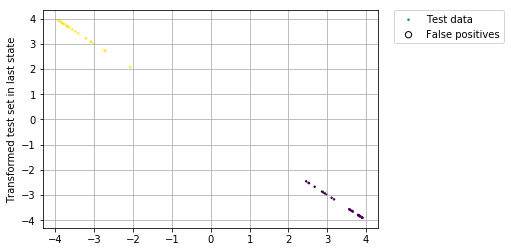

In [33]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BasicNNet(dim_data=2, dim_layers=[100, 100, 30], dim_pred=2, dropout=None, params_init=None)
trainer = BasicNNetTrainer(model=model, regularizer=.001, learning_rate=.001,
                           train_data=train_data, train_labels=train_labels, batch_size=10,
                           test_data=test_data, test_labels=test_labels, dump_freq=100,
                           optimizer=tf.train.AdamOptimizer)
prod_report_easy('hm_nn_ado', prod_report_2d, trainer, n_epochs=100)

# Half-moons on neural net with Adam optimizer (with dropout)

2017-11-05 13:26:27,031|root|INFO|Loading cached training data [../cache/hm_nn_ado_do]


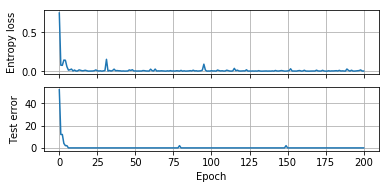

2017-11-05 13:26:27,478|root|INFO|Entropy loss: 0.00, Test error: 0.00


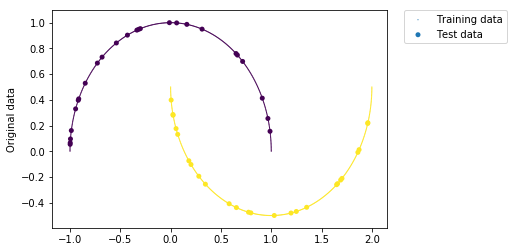

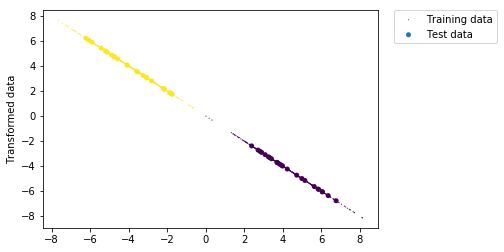

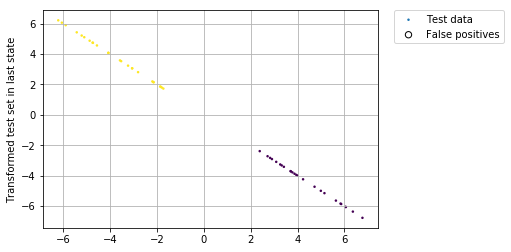

In [34]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BasicNNet(dim_data=2, dim_layers=[100, 100, 30], dim_pred=2, dropout=.5, params_init=None)
trainer = BasicNNetTrainer(model=model, regularizer=.001, learning_rate=.001,
                           train_data=train_data, train_labels=train_labels, batch_size=10,
                           test_data=test_data, test_labels=test_labels, dump_freq=100,
                           optimizer=tf.train.AdamOptimizer)
prod_report_easy('hm_nn_ado_do', prod_report_2d, trainer, n_epochs=200)

# Half-moons on neural net with Adam optimizer (with dropout except 1st layer)

2017-11-05 13:26:28,707|root|INFO|Loading cached training data [../cache/hm_nn_ado_do_1]


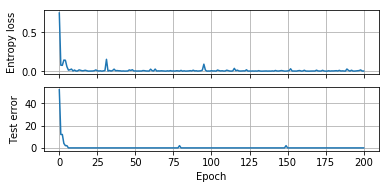

2017-11-05 13:26:29,151|root|INFO|Entropy loss: 0.00, Test error: 0.00


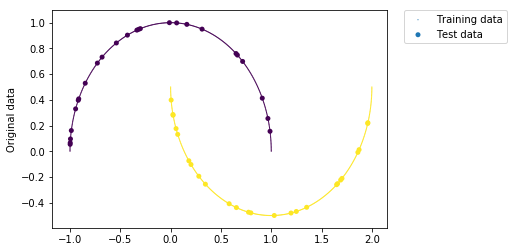

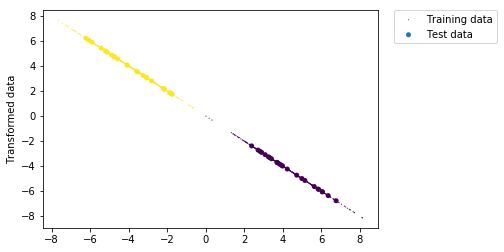

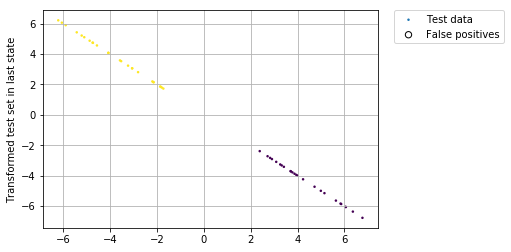

In [35]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BasicNNet(dim_data=2, dim_layers=[100, 100, 30], dim_pred=2, dropout=.5, params_init=None)
trainer = BasicNNetTrainer(model=model, regularizer=.001, learning_rate=.001,
                           train_data=train_data, train_labels=train_labels, batch_size=10,
                           test_data=test_data, test_labels=test_labels, dump_freq=100,
                           optimizer=tf.train.AdamOptimizer)
prod_report_easy('hm_nn_ado_do_1', prod_report_2d, trainer, n_epochs=200)

# Half-moons on boundary set with gradient descent optimizer

2017-11-05 13:26:30,259|root|INFO|Loading cached training data [../cache/hm_bs_gdo]


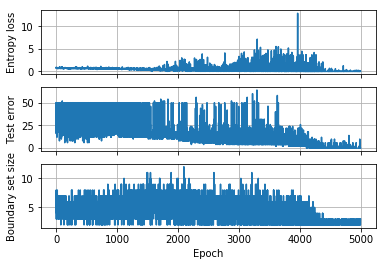

2017-11-05 13:26:30,898|root|INFO|Entropy loss: 0.17, Test error: 1.57


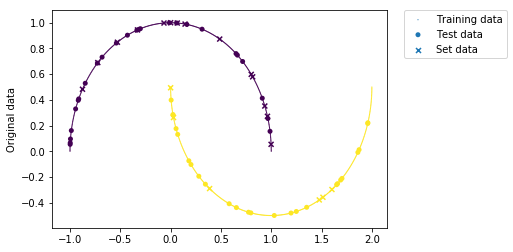

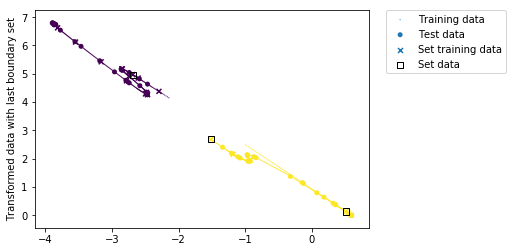

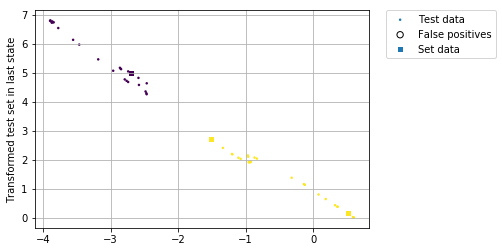

In [36]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BoundaryModel(dim_data=2, dim_layers=[100, 100, 30], dim_inter=2, dim_pred=2, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model=model, regularizer=.005, learning_rate=.0001,
                          train_data=train_data, train_labels=train_labels, set_size=20, batch_size=10,
                          test_data=test_data, test_labels=test_labels, dump_freq=100,
                          optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('hm_bs_gdo', prod_report_2d, trainer, n_epochs=5000)

# Half-moons on boundary set with gradient descent optimizer (with dropout)

2017-11-05 13:26:32,021|root|INFO|Loading cached training data [../cache/hm_bs_gdo_do]


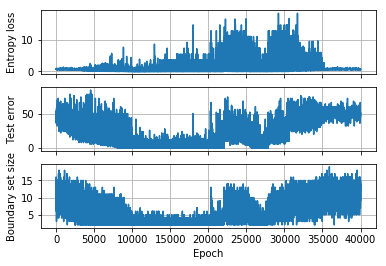

2017-11-05 13:26:32,873|root|INFO|Entropy loss: 0.78, Test error: 45.89


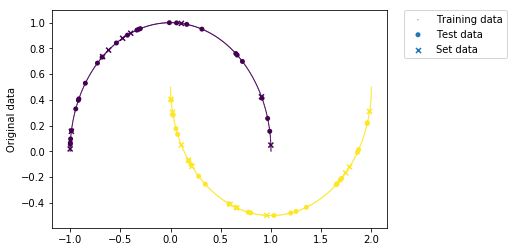

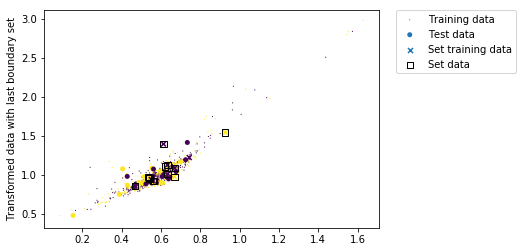

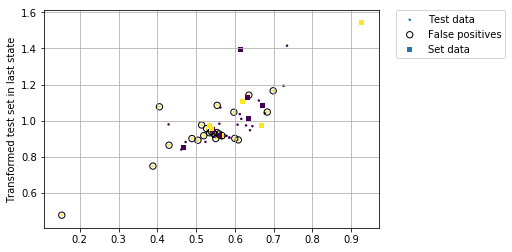

In [37]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BoundaryModel(dim_data=2, dim_layers=[100, 100, 30], dim_inter=2, dim_pred=2, sigma=1, dropout=.5, params_init=None)
trainer = BoundaryTrainer(model=model, regularizer=.005, learning_rate=.0001,
                          train_data=train_data, train_labels=train_labels, set_size=20, batch_size=10,
                          test_data=test_data, test_labels=test_labels, dump_freq=100,
                          optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('hm_bs_gdo_do', prod_report_2d, trainer, n_epochs=40000)

# Half-moons on boundary set with Adam optimizer

2017-11-05 13:26:34,157|root|INFO|Loading cached training data [../cache/hm_bs_ado]


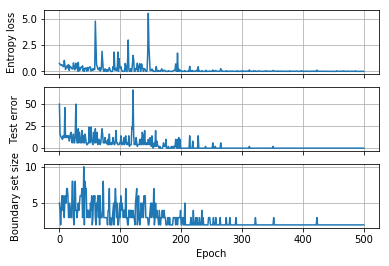

2017-11-05 13:26:34,637|root|INFO|Entropy loss: 0.01, Test error: 0.00


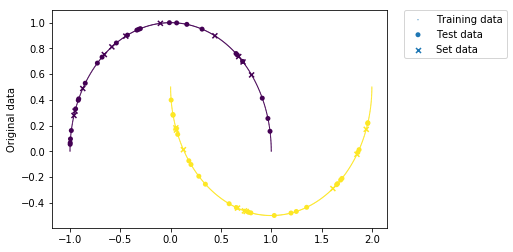

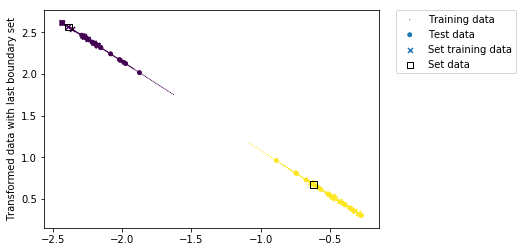

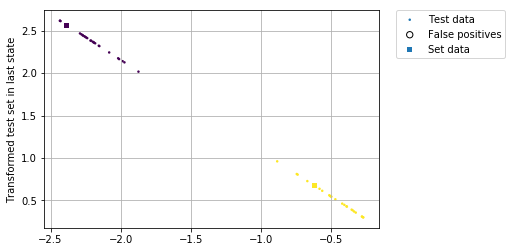

In [38]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BoundaryModel(dim_data=2, dim_layers=[100, 100, 30], dim_inter=2, dim_pred=2, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model=model, regularizer=.005, learning_rate=.0001,
                          train_data=train_data, train_labels=train_labels, set_size=20, batch_size=10,
                          test_data=test_data, test_labels=test_labels, dump_freq=100,
                          optimizer=tf.train.AdamOptimizer)
prod_report_easy('hm_bs_ado', prod_report_2d, trainer, n_epochs=500)

# Half-moons on boundary set with Adam optimizer (with dropout)

2017-11-05 13:26:35,970|root|INFO|Loading cached training data [../cache/hm_bs_ado_do]


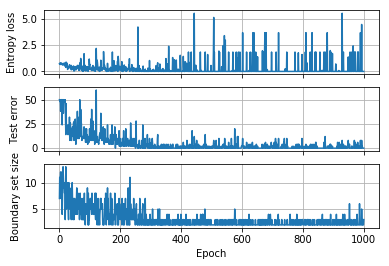

2017-11-05 13:26:36,436|root|INFO|Entropy loss: 0.34, Test error: 1.05


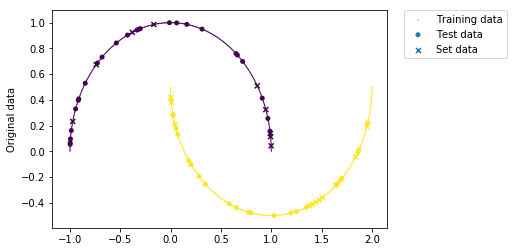

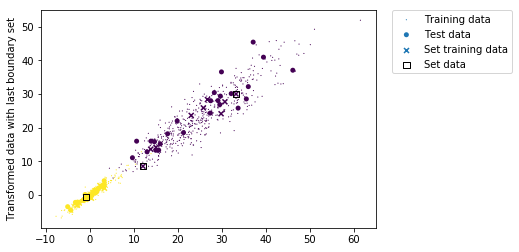

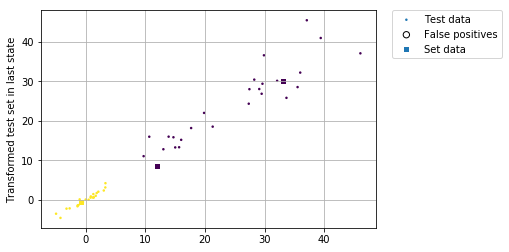

In [39]:
reset_all(1)
train_data, train_labels, test_data, test_labels = make_half_moons(n_training=1000, n_test=50)
model = BoundaryModel(dim_data=2, dim_layers=[100, 100, 30], dim_inter=2, dim_pred=2, sigma=1, dropout=.5, params_init=None)
trainer = BoundaryTrainer(model=model, regularizer=.005, learning_rate=.0001,
                          train_data=train_data, train_labels=train_labels, set_size=20, batch_size=10,
                          test_data=test_data, test_labels=test_labels, dump_freq=100,
                          optimizer=tf.train.AdamOptimizer)
prod_report_easy('hm_bs_ado_do', prod_report_2d, trainer, n_epochs=1000)

# MNIST 2-class on neural net

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 13:27:50,588|root|INFO|Starting training.
2017-11-05 13:28:30,794|root|INFO|Finished training.


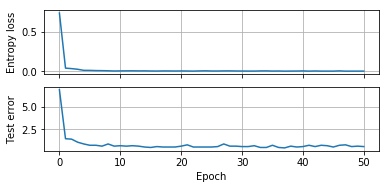

2017-11-05 13:28:31,306|root|INFO|Entropy loss: 0.00, Test error: 0.61


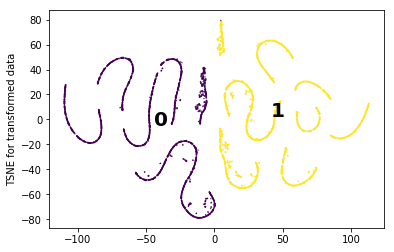

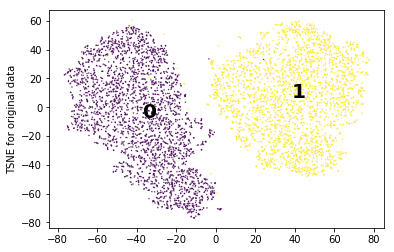

In [41]:
reset_all(1)
train_data, train_labels, test_data, test_labels = load_mnist_digits_2('tensorflow')
model = BasicNNet(dim_data=train_data.shape[1], dim_layers=[400, 400, 20], dim_pred=2, dropout=None, params_init=None)
trainer = BasicNNetTrainer(model, regularizer=.001, learning_rate=.001, train_data=train_data,
                            train_labels=train_labels, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=100)
prod_report_easy('mnist2_nn', prod_report, trainer, n_epochs=50, subset=6000)

# MNIST 2-class on boundary set

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 13:34:01,914|root|INFO|Starting training.
2017-11-05 13:51:15,190|root|INFO|Finished training.


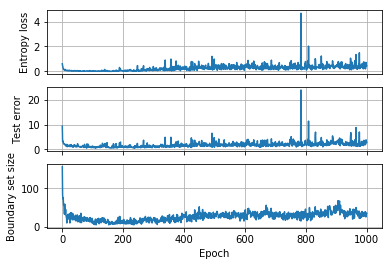

2017-11-05 13:51:16,020|root|INFO|Entropy loss: 0.42, Test error: 2.55


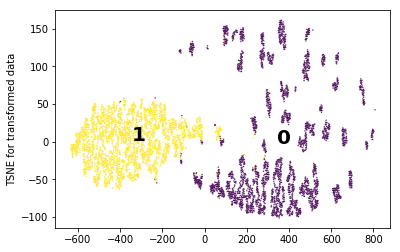

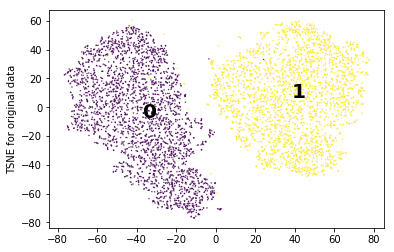

In [42]:
reset_all(1)
train_data, train_labels, test_data, test_labels = load_mnist_digits_2('tensorflow')
model = BoundaryModel(dim_data=train_data.shape[1], dim_layers=[400, 400],
                       dim_inter=20, dim_pred=2, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model, regularizer=.001, learning_rate=.0001, train_data=train_data,
                            train_labels=train_labels, set_size=1000, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=100)
prod_report_easy('mnist2_bs', prod_report, trainer, n_epochs=1000, subset=6000)

# MNIST on neural net

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 13:54:28,900|root|INFO|Starting training.
2017-11-05 14:00:38,192|root|INFO|Finished training.


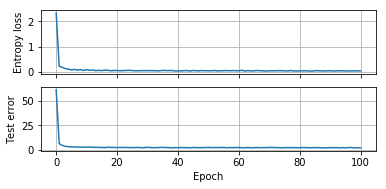

2017-11-05 14:00:39,092|root|INFO|Entropy loss: 0.04, Test error: 1.99


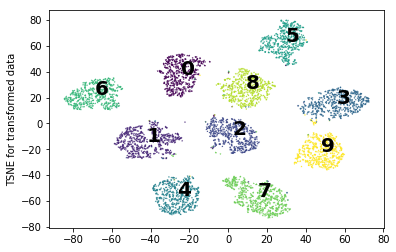

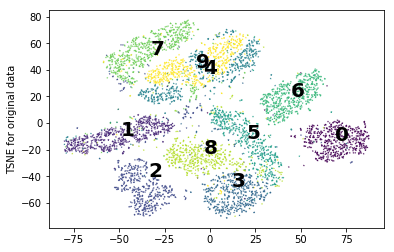

In [43]:
reset_all(1)
train_data, train_labels, test_data, test_labels = load_mnist_digits('tensorflow')
model = BasicNNet(dim_data=train_data.shape[1], dim_layers=[400, 400, 20],
                   dim_pred=10, dropout=None, params_init=None)
trainer = BasicNNetTrainer(model, regularizer=.001, learning_rate=.001, train_data=train_data,
                            train_labels=train_labels, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=200)
prod_report_easy('mnist_nn', prod_report, trainer, n_epochs=100, subset=6000)

# MNIST on neural net with gradient descent optimizer

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 14:05:55,913|root|INFO|Starting training.
2017-11-05 14:55:30,432|root|INFO|Finished training.


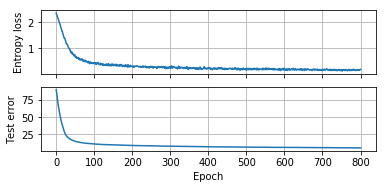

2017-11-05 14:55:31,458|root|INFO|Entropy loss: 0.19, Test error: 5.42


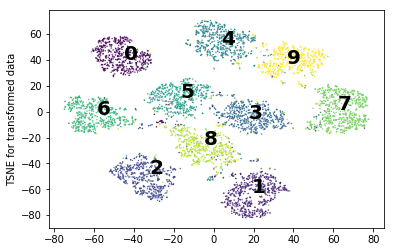

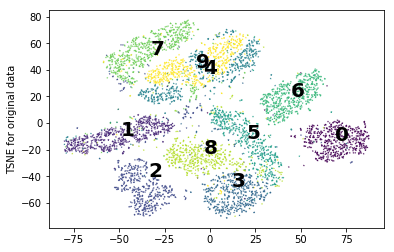

In [44]:
reset_all(1)
train_data, train_labels, test_data, test_labels = load_mnist_digits('tensorflow')
model = BasicNNet(dim_data=train_data.shape[1], dim_layers=[400, 400, 20],
                   dim_pred=10, dropout=None, params_init=None)
trainer = BasicNNetTrainer(model, regularizer=.001, learning_rate=.001, train_data=train_data,
                            train_labels=train_labels, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=200,
                            optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('mnist_nn_gdo', prod_report, trainer, n_epochs=800, subset=6000)

# MNIST on boundary set

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2018-03-03 00:55:27,982|root|INFO|Starting training.
2018-03-03 01:49:28,174|root|INFO|Finished training.


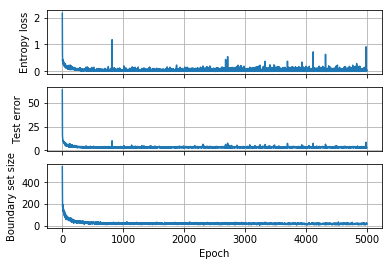

2018-03-03 01:49:39,535|root|INFO|Entropy loss: 0.05, Test error: 3.39


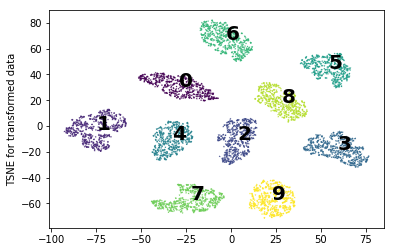

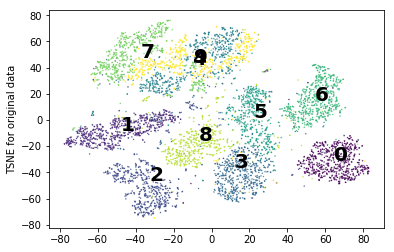

In [2]:
reset_all(565)
#params_init = load_pik('state_300.pik')['params']
#history = load_pik('temp/history.pik')
train_data, train_labels, test_data, test_labels = load_mnist_digits('tensorflow')
model = BoundaryModel(dim_data=train_data.shape[1], dim_layers=[400, 400],
                       dim_inter=20, dim_pred=10, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model, regularizer=.001, learning_rate=.0001, train_data=train_data,
                            train_labels=train_labels, set_size=1000, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=200, decrease_learning_rate_at=[600, 4000])
prod_report_easy('mnist_bs', prod_report, trainer, n_epochs=5000, subset=6000)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 14:57:41,944|root|INFO|Starting training.
2017-11-05 16:20:27,464|root|INFO|Finished training.


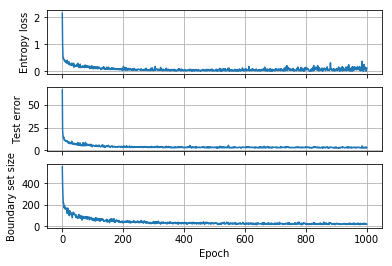

2017-11-05 16:20:28,435|root|INFO|Entropy loss: 0.09, Test error: 3.13


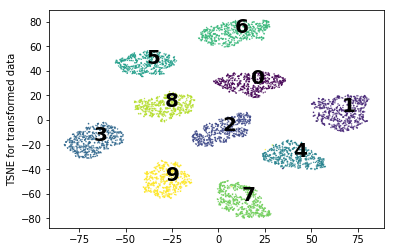

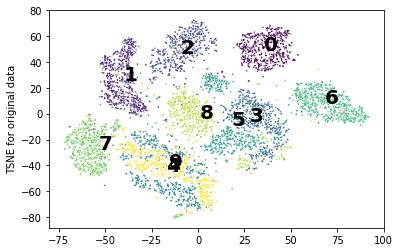

In [45]:
reset_all(565)
#params_init = load_pik('state_300.pik')['params']
#history = load_pik('temp/history.pik')
train_data, train_labels, test_data, test_labels = load_mnist_digits('tensorflow')
model = BoundaryModel(dim_data=train_data.shape[1], dim_layers=[400, 400],
                       dim_inter=20, dim_pred=10, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model, regularizer=.001, learning_rate=.0001, train_data=train_data,
                            train_labels=train_labels, set_size=1000, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=200)
prod_report_easy('mnist_bs', prod_report, trainer, n_epochs=1000, subset=6000)

# Same scatter plots as above with 20,000 data points

2017-11-05 18:11:26,473|root|INFO|Loading cached training data [../cache/mnist_bs]


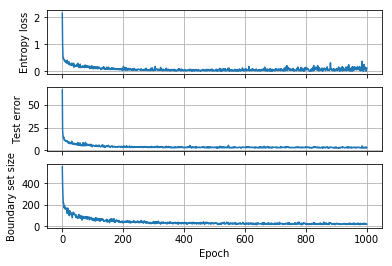

2017-11-05 18:11:27,409|root|INFO|Entropy loss: 0.09, Test error: 3.13


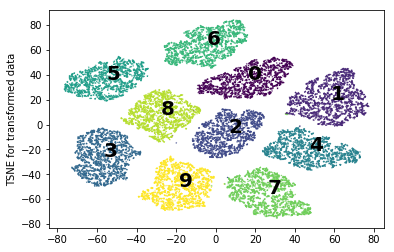

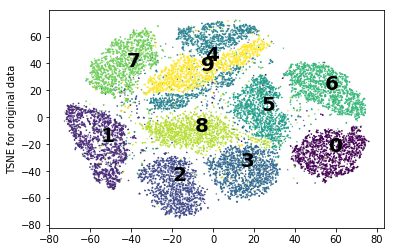

In [ ]:
prod_report_easy('mnist_bs', prod_report, trainer, n_epochs=1000, subset=20000)

# MNIST on boundary set with gradient descent optimizer

In [ ]:
reset_all(565)
train_data, train_labels, test_data, test_labels = load_mnist_digits('tensorflow')
model = BoundaryModel(dim_data=train_data.shape[1], dim_layers=[400, 400],
                       dim_inter=20, dim_pred=10, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model, regularizer=.001, learning_rate=.0001, train_data=train_data,
                            train_labels=train_labels, set_size=1000, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=200,
                            optimizer=tf.train.GradientDescentOptimizer)
prod_report_easy('mnist_bs_gdo', prod_report, trainer, n_epochs=4000, subset=6000)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 23:08:54,060|root|INFO|Starting training.


# MNIST on boundary set with intermediate dim = 2

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


2017-11-05 21:00:47,886|root|INFO|Starting training.
2017-11-05 22:21:12,643|root|INFO|Finished training.


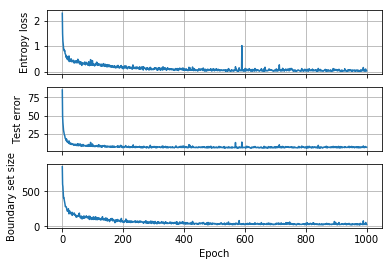

2017-11-05 22:21:13,770|root|INFO|Entropy loss: 0.05, Test error: 6.45


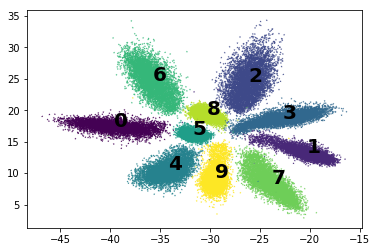

In [2]:
reset_all(565)
train_data, train_labels, test_data, test_labels = load_mnist_digits('tensorflow')
model = BoundaryModel(dim_data=train_data.shape[1], dim_layers=[400, 400],
                       dim_inter=2, dim_pred=10, sigma=1, dropout=None, params_init=None)
trainer = BoundaryTrainer(model, regularizer=.001, learning_rate=.0001, train_data=train_data,
                            train_labels=train_labels, set_size=1000, batch_size=1000,
                            test_data=test_data, test_labels=test_labels, dump_freq=200)
prod_report_easy('mnist_bs2', prod_trans_2d, trainer, n_epochs=1000)